### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for `Average Temperature`

##  Read Me

This scripts contains ML model building steps for the weather variable `Average Temperature`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. The modeling involves the following steps-

1. Loading Data
2. Evaluation before model performance/relationship 
3. additional data filtering 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- __TWC doesn't have an average temperature estimate. One approach is resampling 28km ERA5 data to 4km and use it to the environmental model. Another approach is- calculating TWC average temperature from TWC min and max temperature data and use it as a training data in a ML model to produce high resolution (4km) avg temperature data. Note that ERA5 doesn't have average temperature attribute either, so we have to depend on other variables of ERA5 to produce high resolution averager temperature estimate.__ 
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [3]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

------------------

## 1. Loading Data

The `combined dataset` parquet file consists of weather datasets from ERA5 and TWC, along with topography and lat/lon data. Importing ERA5 and TWC datasets as well to briefly look into which variables belong to which source. 

__We are going to use TWC Max Temp and Min Temp data to estimate `Averager Temperature` variable and going to use the estimated `Average Temperature` data as the training data.__

In [4]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

twc_df =pd.read_parquet(twc_data)
era5_df = pd.read_parquet(era5_data)
combined_df = pd.read_parquet(combined_dataset)

# Calculating TWC Average Temperature 
combined_df['avg_temp_twc'] = combined_df[['min_temp_twc', 'max_temp_twc']].mean(axis=1)

print(f'TWC df columns: {twc_df.columns}')
print(f'ERA5 df columns: {era5_df.columns}')
print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC df columns: Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')
ERA5 df columns: Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')
TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',


--------------------

## 2. Additional data filtering

__Filtering out rows after 2019-08. TWC weather data, especially temperature data has resolution issue (1 degree resolution, no intermediate float values). Therefore, not including them in model training.__

In [5]:
ml_df = combined_df[combined_df.date <=20190730]
sorted(ml_df.date)[0], sorted(ml_df.date)[-1]

(20150630, 20190730)

In [6]:
ml_df.head()

,index,avg_wind_speed_twc,date,year,month,day,lon,lat,avg_Rhumid_twc,max_temp_twc,...,avg_atmPress,max_dew_temp,avg_SM_L1,avg_dew_temp,avg_wind_dir,avg_Rhumid_era5,etr,avg_ST_L1,avg_snow_depth,avg_temp_twc
0,8,6.8,20150630,2015,6,30,-122.126717,39.413143,34.500000,43.500000,...,1004.137024,15.034322,0.125888,9.906414,136.549652,26.554916,9.592988,32.786526,0.0,30.900000
1,9,6.8,20150630,2015,6,30,-122.090721,39.413143,35.200001,43.299999,...,1007.559509,14.924334,0.128197,10.183108,136.920456,26.782413,9.618893,32.849823,0.0,30.849998
2,10,6.6,20150630,2015,6,30,-122.054718,39.413143,36.500000,43.099998,...,1009.995972,14.890730,0.130000,10.443419,136.933441,27.072355,9.602571,32.870281,0.0,30.699999
3,11,6.6,20150630,2015,6,30,-122.018715,39.413143,36.500000,43.099998,...,1008.910706,15.129926,0.130000,10.645221,135.668533,27.585321,9.435449,32.737732,0.0,30.699999
4,86,7.7,20150630,2015,6,30,-122.234718,39.377144,30.299999,43.799999,...,992.963196,15.414620,0.117964,9.033833,138.349487,26.006777,9.448297,32.584099,0.0,31.900000


-------------------

## 3. Evaluation before model performance/relationship

Both ERA5 and TWC datasets don't have `Average Temperature` estimate. We already calculated `TWC Average Temperature` in `step 1`. In this step 3, we are going to estimate `ERA5 Average Temperature` using ERA5 Max and Min Temperature Data. This estimated `ERA5 Average Temperature` data can be considered as the `resampled ERA5 (4km) Average Temperature` data and we can calculate R2 between  `resampled ERA5 (4km) Average Temperature` and `estimated TWC Average Temperature` data to do a before modeling comparison.

/tmp/ipykernel_21468/2122228740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_ml_df['avg_temp_era5'] = (new_ml_df['max_temp_era5'] + new_ml_df['min_temp_era5']) / 2


RMSE before modeling = 1.788
R2 before modeling= 0.936


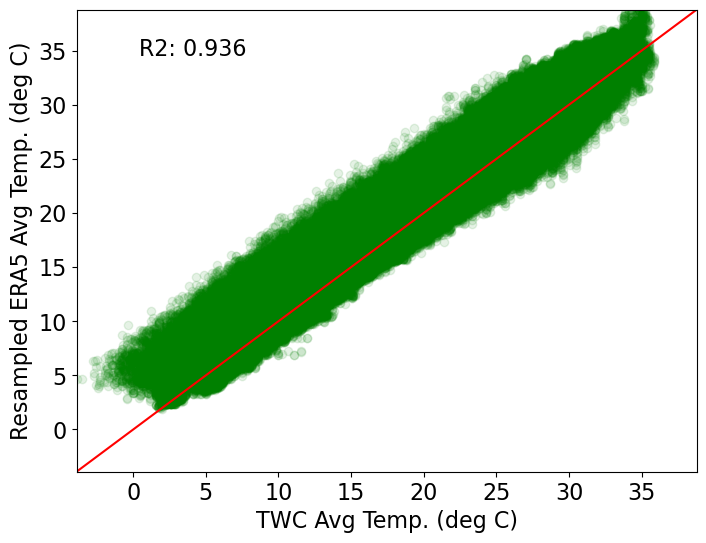

In [7]:
# copying dataframe into a new dataframe for cmparison purpose only
new_ml_df = ml_df

# calculating ERA5 Average Temperature
new_ml_df['avg_temp_era5'] = (new_ml_df['max_temp_era5'] + new_ml_df['min_temp_era5']) / 2 

# calculating RMSE and R2
rmse = calculate_rmse(Y_pred=new_ml_df['avg_temp_era5'], Y_obsv=new_ml_df['avg_temp_twc'])
r2 = calculate_r2(Y_pred=new_ml_df['avg_temp_era5'], Y_obsv=new_ml_df['avg_temp_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=new_ml_df['avg_temp_era5'], Y_obsv=new_ml_df['avg_temp_twc'], xlabel='TWC Avg Temp. (deg C)', 
             ylabel='Resampled ERA5 Avg Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, color_format='go')

## Goal

The R2 value between TWC and ERA5 average temp is quite well.However, We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution average temperature using TWC Max Temperature as the training data.

---------------------

## 4. Making train-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `Average Temperature`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `Average Temperature` has been used as the training/observed data.

In [9]:
drop_columns = ['index', 'year', 'day',
                'avg_Rhumid_twc', 'avg_wind_speed_twc', 'max_temp_twc', 'min_temp_twc',
                'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 
                'avg_Cloud', 'avg_wind_speed_era5', 'max_atmPress', 'min_atmPress', 'avg_atmPress',
                'min_wind_speed', 'avg_snow_depth', 'min_Rhumid', 'max_Rhumid']

# using combined_df as the input dataset here as combined saved dataset doesn't have a avg_temp_twc column
x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=ml_df, pred_attr='avg_temp_twc', 
exclude_columns=drop_columns, test_perc=0.3, validation_perc=0)

Dropping Columns- ['index', 'year', 'day', 'avg_Rhumid_twc', 'avg_wind_speed_twc', 'max_temp_twc', 'min_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 'avg_Cloud', 'avg_wind_speed_era5', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed', 'avg_snow_depth', 'min_Rhumid', 'max_Rhumid'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect',
       'avg_Rhumid_era5', 'avg_dew_temp', 'avg_temp_era5', 'avg_wind_dir',
       'elevation', 'lat', 'lon', 'max_dew_temp', 'max_temp_era5',
       'max_wind_speed', 'min_dew_temp', 'min_temp_era5', 'month', 'slope',
       'total_precip'],
      dtype='object')


__As we are using CV for hyperparameter tuning, not creating any validation dataset.__

In [10]:
print('x_train length', len(x_train))
print('x_val length', len(x_val))
print('x_test length', len(x_test))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')
print(f'num. of test dates: {len(test_dates)}')

x_train length 1583120
x_val length 0
x_test length 679140
num. of training dates: 1028
num. of validation dates: 0
num. of test dates: 441


---------------------------

## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

max_temp_era5      1.400514
min_temp_era5      1.155235
month              0.758419
TotDown_SR         0.627292
TotNet_SR          0.586997
MaxDown_SR         0.573113
MaxNet_SR          0.535782
avg_Rhumid_era5    0.408190
max_dew_temp       0.383302
min_Rhumid         0.368517
max_Rhumid         0.347949
avg_dew_temp       0.331015
min_dew_temp       0.223521
max_wind_speed     0.168177
total_precip       0.149567
avg_wind_dir       0.126274
elevation          0.067178
slope              0.065459
aspect             0.064479
lat                0.032252
lon                0.029274
dtype: float64

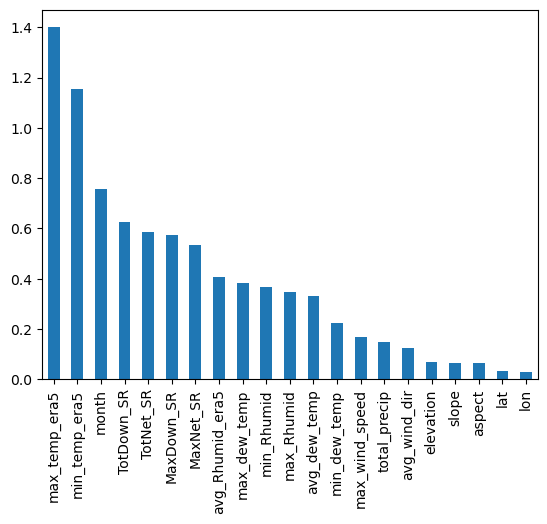

In [11]:
mutual_info_temp = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_temp

`lat/lon/month/day' might have less MI score. But I recommend keeping them in the model. Especially, the model will be trained with datasets of very different lat/lon, these variables might become crucial predictors`

----------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [11]:
# when tuning hyperparameters set params_dict=None.
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.7,
                   'colsample_bytree': 0.8,
                   'colsample_bynode': 0.7 ,
                   'path_smooth': 0.2,
                   'num_leaves': 70,
                   'min_child_samples': 40,
                   'data_sample_strategy': 'goss'
                  }
trained_lgbm_avgtemp = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                                   load_model=False, save_model=True, save_folder='./saved_models', save_name='lgbm_avg_temp',
                                   # hyperparameter tuning arguments
                                   tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 4531
[LightGBM] [Info] Number of data points in the train set: 1583120, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 17.641496
Train RMSE = 0.721
Train R2 = 0.989
model training time 0.186 mins


In [12]:
trained_lgbm_avgtemp

LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.8,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              min_child_samples=40, n_estimators=250, n_jobs=-1, num_leaves=70,
              path_smooth=0.2, random_state=0, subsample=0.7,
              tree_learner='serial')

----------------------

## 7. Train-test dataset perforamnce evaluation

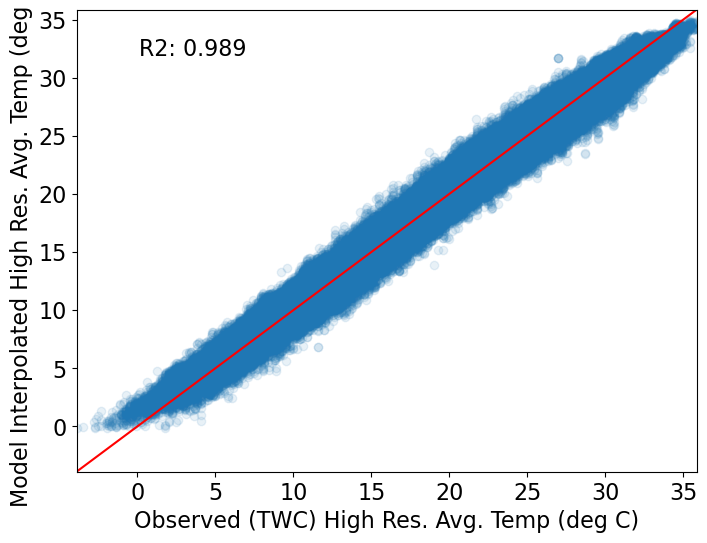

In [12]:
y_pred_train = trained_lgbm_avgtemp.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Model Interpolated High Res. Avg. Temp (deg C)', 
             title=None, savedir=None, plot_name=None, alpha=0.1)

Test RMSE = 0.827
Test R2 = 0.987


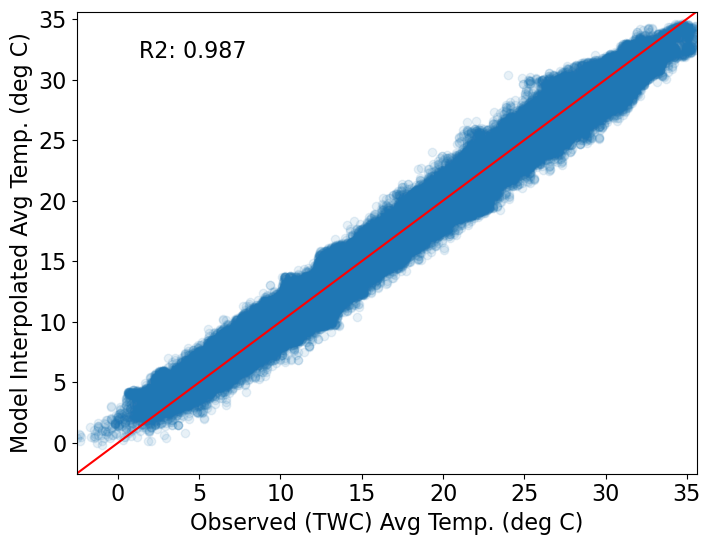

In [13]:
# Performance on test dataset
y_pred_test = trained_lgbm_avgtemp.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))


scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='Observed (TWC) Avg Temp. (deg C)', ylabel='Model Interpolated Avg Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

---------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

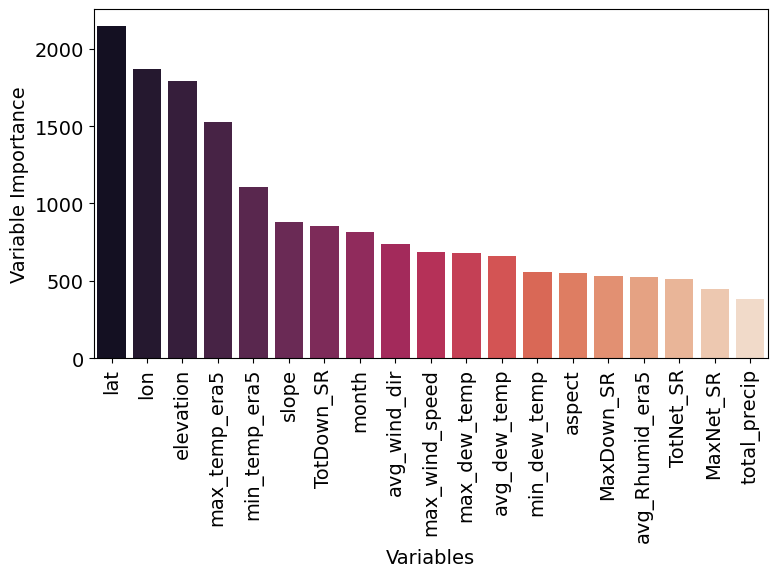

In [11]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_avgtemp, x_train=x_train, outdir=None, predictor_imp_keyword='rf')

-----------------------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

__The combined dataset contains data after 2019-08 that was later filtered out in ml_df. However, we are using the combined_df (cmobined_dataset) to test performace for randomly selected dates which are in test dataset. Also, we are checking performance of dates after 2019-08 (with resolution issue) for which the model wasn't trained for.__


__We are only showing after modeling performance in this case as we don't have the ERA5 Average Temperature Data. In general, the model should do quite well for average temperature (similar to max and min temperature).__

In [12]:
test_dates[1:30]

[20180202,
 20181223,
 20160703,
 20160719,
 20180910,
 20151226,
 20170417,
 20170903,
 20160728,
 20180523,
 20181122,
 20170516,
 20190618,
 20180604,
 20181025,
 20170221,
 20170605,
 20161008,
 20170418,
 20150630,
 20171214,
 20180803,
 20180807,
 20160417,
 20151016,
 20160207,
 20170928,
 20160313,
 20190525]

In [13]:
# to check if a date is in test dataset
if 20160410 in test_dates:
    print(True)

True


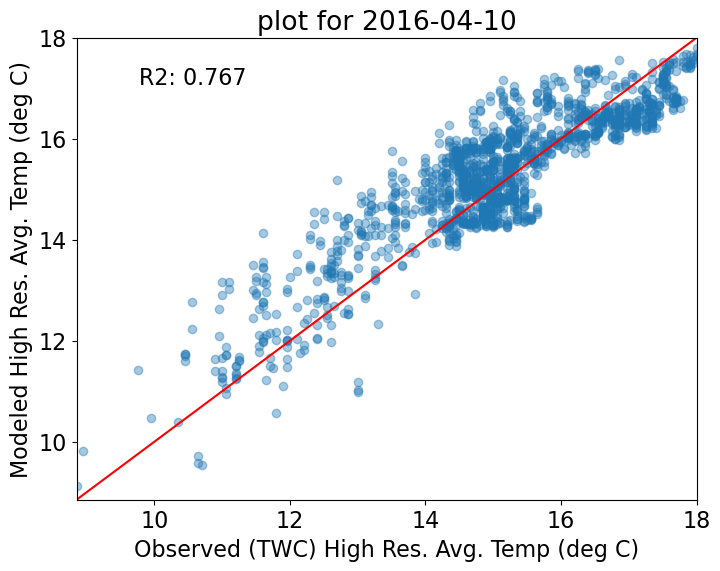

In [14]:
twc_era5_df_sample = combined_df[combined_df.date==20160410]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_temp_twc']].values 

y_pred_train = trained_lgbm_avgtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Modeled High Res. Avg. Temp (deg C)', 
             title='plot for 2016-04-10', alpha=0.4)

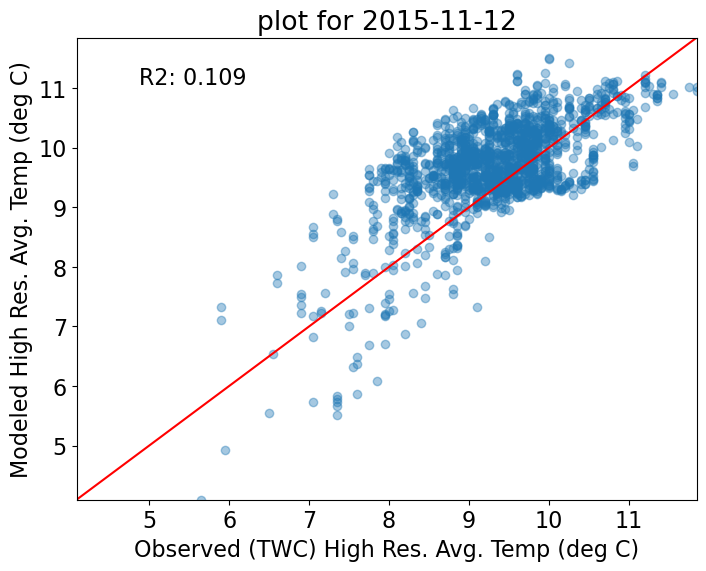

In [15]:
twc_era5_df_sample = combined_df[combined_df.date==20151112]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_temp_twc']].values 

y_pred_train = trained_lgbm_avgtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Modeled High Res. Avg. Temp (deg C)', 
             title='plot for 2015-11-12', alpha=0.4)

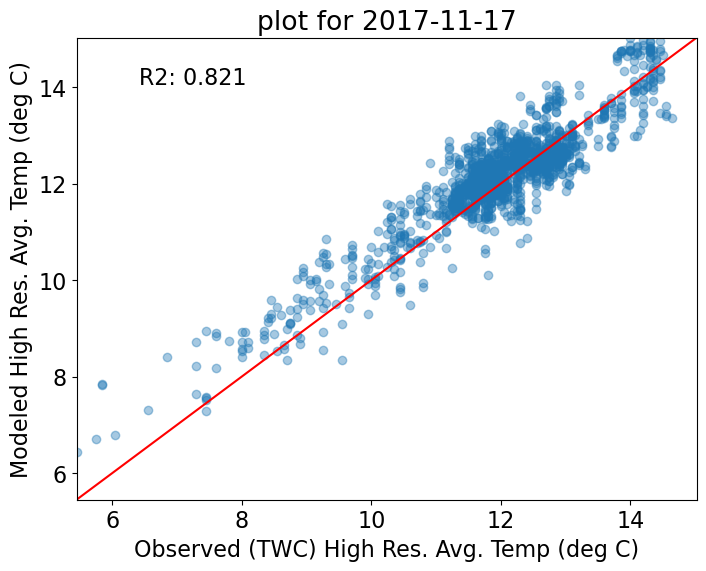

In [16]:
twc_era5_df_sample = combined_df[combined_df.date==20171117]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_temp_twc']].values 

y_pred_train = trained_lgbm_avgtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Modeled High Res. Avg. Temp (deg C)', 
             title='plot for 2017-11-17', alpha=0.4)

### Dates after 2019-08

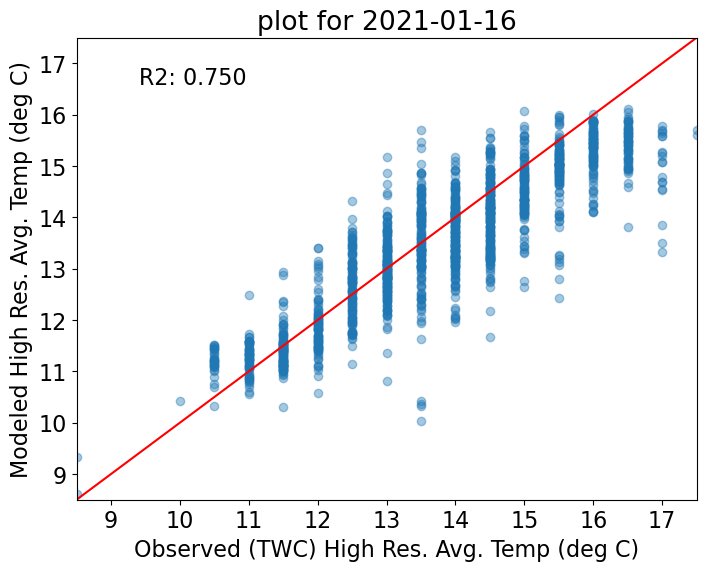

In [17]:
twc_era5_df_sample = combined_df[combined_df.date==20210116]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_temp_twc']].values 

y_pred_train = trained_lgbm_avgtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Modeled High Res. Avg. Temp (deg C)', 
             title='plot for 2021-01-16', alpha=0.4)

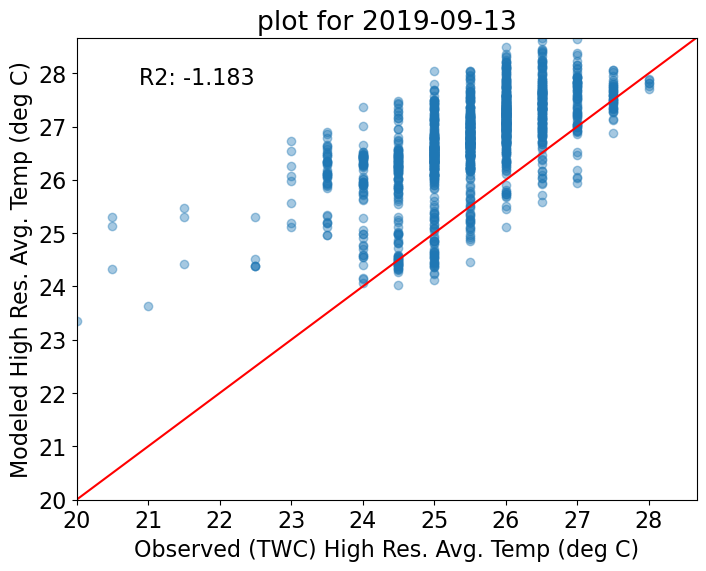

In [18]:
twc_era5_df_sample = combined_df[combined_df.date==20190913]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_temp_twc']].values 

y_pred_train = trained_lgbm_avgtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Avg. Temp (deg C)', ylabel='Modeled High Res. Avg. Temp (deg C)', 
             title='plot for 2019-09-13', alpha=0.4)

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is performing quite well for individual dates.__

-----------------

## 10. Estimating overall model perforamcne on test dataset

__We are only showing before-after modeling performance (boxplot) in this case as we don't have the ERA5 Average Temperature Data. In general, the model should do quite well for average temperature (similar to max and min temperature).__

-----------------------

## 11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

In [19]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/min_temp/min_temp_20150630.tif'
output_folder = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_temp'

run_model_to_generate_prediction(trained_ml_model=trained_lgbm_avgtemp, x_train=x_train, 
                                 predictor_era5_dataset=era5_data, ref_raster=ref_raster, 
                                 output_folder=output_folder, variable_name_keyword='avg_temp')

Generating model interpolated daily rasters...
All daily rasters generated
